In [74]:
from rootpy.io import root_open
from root_numpy import root2array 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import matplotlib.ticker as ticker
import pickle
import os.path as op

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten, concatenate
from keras.layers.merge import _Merge
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
from keras import backend as K

import random

In [75]:
save = 'False'

# Load True data (MC)

Here, we load energy deposits and total energy of each events. Both have already been preprocessed (see PreProcessing.py).

In [76]:
data_path = '/media/pklein/33fd2f13-8113-44ae-9dab-6d98aa410224/pklein/Documents/CERN/DATA/condWGAN_0'
X_t = np.load(op.join(data_path, 'X_clean.npy')) #X_true (MC)
E_tot = np.load(op.join(data_path, 'E_tot.npy'))

In [77]:
print("Dataset containing:\n\
- {} events\n\
- and a cluster of {} cells energy deposit for each one".format(X_t.shape[0], X_t.shape[1]))

Dataset containing:
- 41118 events
- and a cluster of 89 cells energy deposit for each one


We build our former dataset in order to have ntuples (ROOT format). We can load them as numpy arrays with root_numpy, and select features of our interest. It will be useful to compute physics variables later (we'll need cells eta and phi coordinates for instance)

In [78]:
f = root_open("/media/pklein/33fd2f13-8113-44ae-9dab-6d98aa410224//pklein/Documents/CERN/Dataset/outputTree_10files_Cluster_tru.root")
path = '/media/pklein/33fd2f13-8113-44ae-9dab-6d98aa410224//pklein/Documents/CERN/Plots/'
t = f.tau

a = root2array("/media/pklein/33fd2f13-8113-44ae-9dab-6d98aa410224//pklein/Documents/CERN/Dataset/cluster_ok.root", "tau", ["off_cells_e",
                                                                              "off_cells_samp",
                                                                              "off_ncells",
                                                                              "off_cells_eta",
                                                                              "off_cells_phi",
                                                                              "off_pt", ])

### Suppress events>300GeV

In [79]:
indices = np.load('indices.npy')
a = np.delete(a, indices, axis=0)

### Deal with wrapping in Phi

In [80]:
from math import pi
pi = round(pi, 8)

In [81]:
for i in range(a.shape[0]):
    min = a[i][4][:89].min()
    max = a[i][4][:89].max()
    
    if ((max - min)>6):
        idx = np.where(a[i][4][:89]<0)
        for j in idx:
            a[i][4][j] += 2*pi

# Load Generated data

We then generate samples with our WGAN to compare with MC distributions. For that, we load saved weights of the Generator net after training. We consider the union of 5 trained seeds to reduce intrinsic variance.

In [82]:
# path to reach trained models
models_path = '/media/pklein/33fd2f13-8113-44ae-9dab-6d98aa410224/pklein/Documents/CERN/GRID_scripts/Amir_Grid/Averaged_Models/L1'

#Standard Scaler (sklearn) used for energy preprocessing
with open('/media/pklein/33fd2f13-8113-44ae-9dab-6d98aa410224//pklein/Documents/CERN/DATA/condWGAN_0/Analyze/scaler_E_tot.pickle', 'rb') as handle:
    scaler = pickle.load(handle)

In [83]:
SIZE_Z = 100 #latent
n_cells = 89 #cluster cells
seeds = 5    #nb of trained WGAN
epoch = 1000 #nb of trained epoch

In [84]:
def make_generator():

    g_input_noise = Input(shape=(SIZE_Z,), name='Input_noise') # latent space
    g_input_energy = Input(shape=(1,), name='Input_Energy') # conditional energy of the event
    g_input = concatenate([g_input_noise, g_input_energy], axis=-1)
    x = Dense(128)(g_input)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = LeakyReLU()(x)
    outputs = Dense(n_cells, activation='softmax')(x) # softmax to ensure energy conservation
    G = Model(inputs=[g_input_noise, g_input_energy], outputs=outputs)

    return G

In [85]:
generator_11 = make_generator()
generator_12 = make_generator()
generator_13 = make_generator()
generator_14 = make_generator()
generator_15 = make_generator()

In [86]:
generator_11.load_weights(op.join(models_path, 'L1_0/{}/Epoch_{}/generator_weights_EPOCH{}.h5'.format('Seed_1', epoch, epoch)))
generator_12.load_weights(op.join(models_path, 'L1_0/{}/Epoch_{}/generator_weights_EPOCH{}.h5'.format('Seed_2', epoch, epoch)))
generator_13.load_weights(op.join(models_path, 'L1_0/{}/Epoch_{}/generator_weights_EPOCH{}.h5'.format('Seed_3', epoch, epoch)))
generator_14.load_weights(op.join(models_path, 'L1_0/{}/Epoch_{}/generator_weights_EPOCH{}.h5'.format('Seed_4', epoch, epoch)))
generator_15.load_weights(op.join(models_path, 'L1_0/{}/Epoch_{}/generator_weights_EPOCH{}.h5'.format('Seed_5', epoch, epoch)))

To generate samples, we feed the Generator with noise (normal distribution here), and with a conditional energy. Outputs of the WGAN will be normalized so we have to multiply by the real energy of the event to obtain values in MeV.

In [87]:
E_ = scaler.inverse_transform(E_tot) #Apply inverse StandardScaler

X_gen_norm = generator_11.predict([np.random.normal(0,1,(X_t.shape[0], SIZE_Z)).astype(np.float32), E_tot])
X_g11 = X_gen_norm * np.exp(E_.reshape(E_.shape[0])[:,np.newaxis])

X_gen_norm = generator_12.predict([np.random.normal(0,1,(X_t.shape[0], SIZE_Z)).astype(np.float32), E_tot])
X_g12 = X_gen_norm * np.exp(E_.reshape(E_.shape[0])[:,np.newaxis])

X_gen_norm = generator_13.predict([np.random.normal(0,1,(X_t.shape[0], SIZE_Z)).astype(np.float32), E_tot])
X_g13 = X_gen_norm * np.exp(E_.reshape(E_.shape[0])[:,np.newaxis])

X_gen_norm = generator_14.predict([np.random.normal(0,1,(X_t.shape[0], SIZE_Z)).astype(np.float32), E_tot])
X_g14 = X_gen_norm * np.exp(E_.reshape(E_.shape[0])[:,np.newaxis])

X_gen_norm = generator_15.predict([np.random.normal(0,1,(X_t.shape[0], SIZE_Z)).astype(np.float32), E_tot])
X_g15 = X_gen_norm * np.exp(E_.reshape(E_.shape[0])[:,np.newaxis])

In [88]:
# union of generated samples L1=0 (5 seeds)
X_g = np.concatenate((X_g11, X_g12, X_g13, X_g14, X_g15), axis=0 ) 

### Remove electronic noise in Generated samples ?

In [89]:
for i in range(X_g.shape[0]):
    for j in range(89):
        if (j<21) & (X_g[i][j] < 200): #MIDDLE layer (threshold=200MeV)
            X_g[i][j] = 0
        elif (21<=j<69) & (X_g[i][j] < 60): #STRIP layer (threshold=60MeV)
            X_g[i][j] = 0
        elif (69<=j<75) & (X_g[i][j] < 120): #SAMPLER layer (threshold=120MeV)
            X_g[i][j] = 0
        elif (75<=j<89) & (X_g[i][j] < 200): #BACK layer (threshold=200MeV)
            X_g[i][j] = 0

# Total energy per event

In [17]:
E_tot_t = np.array([X_i.sum() for X_i in X_t])
E_tot_g = np.array([X_i.sum() for X_i in X_g])

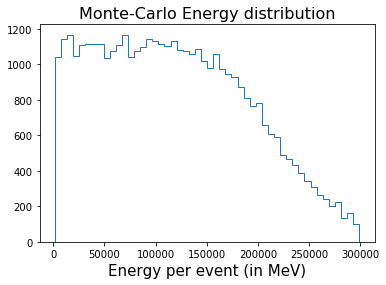

In [18]:
plt.hist(E_tot_t, histtype='step', bins=50)
plt.xlabel('Energy per event (in MeV)', fontsize=15)
plt.title('Monte-Carlo Energy distribution', fontsize=16)
plt.savefig('Distribution.pdf', dpi=600)
plt.show()

# Energies per layer

Here we compute the energy per layer (and per sample). All histograms have been normed.

We have an output of size (n_events * n_layers), in a line we have respectively (Pre-Sampler, Strip, Middle, Back)

In [19]:
E_layer_t = np.zeros((X_t.shape[0], 4))
for i in range(E_layer_t.shape[0]):
    E_layer_t[i][0] = X_t[i][69:75].sum() #Pre_sampler
    E_layer_t[i][1] = X_t[i][21:69].sum() #Strip
    E_layer_t[i][2] = X_t[i][:21].sum() #Middle
    E_layer_t[i][3] = X_t[i][75:89].sum() #Back

In [20]:
E_layer_g = np.zeros((X_g.shape[0], 4))
for i in range(E_layer_g.shape[0]):
    E_layer_g[i][0] = X_g[i][69:75].sum() #Pre_sampler
    E_layer_g[i][1] = X_g[i][21:69].sum() #Strip
    E_layer_g[i][2] = X_g[i][:21].sum() #Middle
    E_layer_g[i][3] = X_g[i][75:89].sum() #Back

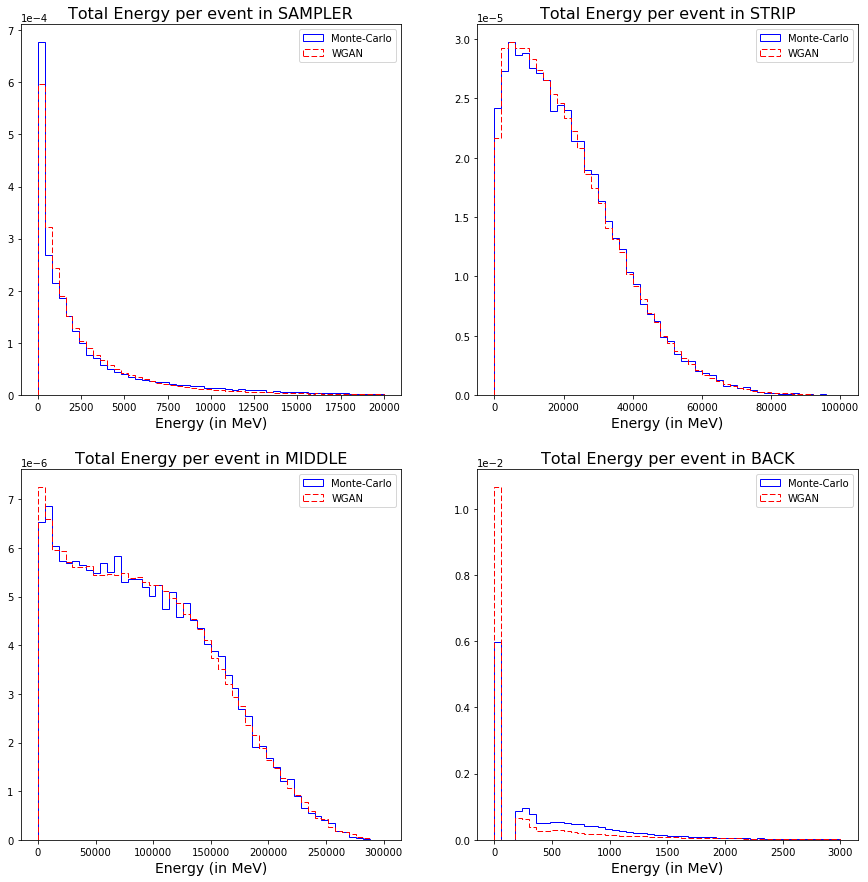

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0, 0].hist(E_layer_t[:,0], bins=50, range=(0,20000), color='b', normed=1, histtype='step', label="Monte-Carlo")
ax[0, 0].hist(E_layer_g[:,0], bins=50, range=(0,20000), color='r', normed=1, histtype='step', label="WGAN", linestyle='--')
ax[0, 0].set_title('Total Energy per event in SAMPLER', fontsize=16)
ax[0, 0].legend()
ax[0, 0].set_xlabel('Energy (in MeV)', fontsize=14)
ax[0, 0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[0, 1].hist(E_layer_t[:,1], bins=50, range=(0,100000), color='b', normed=1, histtype='step', label="Monte-Carlo")
ax[0, 1].hist(E_layer_g[:,1], bins=50, range=(0,100000), color='r', normed=1, histtype='step', label="WGAN", linestyle='--')
ax[0, 1].set_title('Total Energy per event in STRIP', fontsize=16)
ax[0, 1].legend()
ax[0, 1].set_xlabel('Energy (in MeV)', fontsize=14)
ax[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[1, 0].hist(E_layer_t[:,2], bins=50, range=(0,300000), color='b', normed=1, histtype='step', label="Monte-Carlo")
ax[1, 0].hist(E_layer_g[:,2], bins=50, range=(0,300000), color='r', normed=1, histtype='step', label="WGAN", linestyle='--')
ax[1, 0].set_title('Total Energy per event in MIDDLE', fontsize=16)
ax[1, 0].legend()
ax[1, 0].set_xlabel('Energy (in MeV)', fontsize=14)
ax[1, 0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[1, 1].hist(E_layer_t[:,3], bins=50, range=(0,3000), color='b', normed=1, histtype='step', label="Monte-Carlo")
ax[1, 1].hist(E_layer_g[:,3], bins=50, range=(0,3000), color='r', normed=1, histtype='step', label="WGAN", linestyle='--')
ax[1, 1].set_title('Total Energy per event in BACK', fontsize=16)
ax[1, 1].legend()
ax[1,1].set_xlabel('Energy (in MeV)', fontsize=14)
ax[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

if save == 'True':
    plt.savefig(path+'Enegies per layer.pdf', dpi=600)
plt.show()

### Fraction d'energies Layer/Total 

Percent of energy per layer for each event.

In [22]:
# Normalized energies per layer
E_layer_norm_t = np.zeros((X_t.shape[0], 4))
for i in range(X_t.shape[0]):
    for j in range(4):
        E_layer_norm_t[i][j] = E_layer_t[i][j]/E_tot_t[i]
        
E_layer_norm_g = np.zeros((X_g.shape[0], 4))
for i in range(X_g.shape[0]):
    for j in range(4):
        E_layer_norm_g[i][j] = E_layer_g[i][j]/E_tot_g[i]

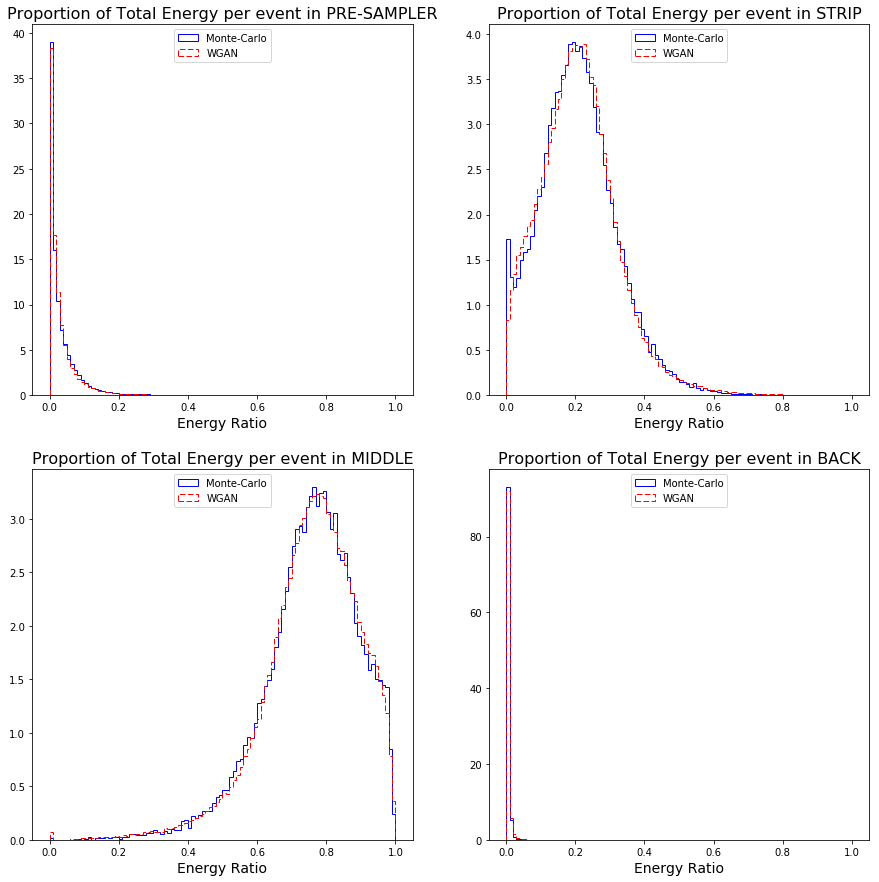

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0, 0].hist(E_layer_norm_t[:,0], bins=100, range=(0,1), color='b', normed=1, histtype='step', label="Monte-Carlo")
ax[0, 0].hist(E_layer_norm_g[:,0], bins=100, range=(0,1), color='r', normed=1,histtype='step', label="WGAN", linestyle='--')
ax[0, 0].set_title('Proportion of Total Energy per event in PRE-SAMPLER', fontsize=16)
ax[0, 0].legend(loc='upper center')
ax[0, 0].set_xlabel('Energy Ratio', fontsize=14)

ax[0, 1].hist(E_layer_norm_t[:,1], bins=100, range=(0,1), color='b', normed=1,histtype='step', label="Monte-Carlo")
ax[0, 1].hist(E_layer_norm_g[:,1], bins=100, range=(0,1), color='r', normed=1,histtype='step', label="WGAN", linestyle='--')
ax[0, 1].set_title('Proportion of Total Energy per event in STRIP', fontsize=16)
ax[0, 1].legend(loc='upper center')
ax[0, 1].set_xlabel('Energy Ratio', fontsize=14)

ax[1, 0].hist(E_layer_norm_t[:,2], bins=100, range=(0,1), color='b', normed=1,histtype='step', label="Monte-Carlo")
ax[1, 0].hist(E_layer_norm_g[:,2], bins=100, range=(0,1), color='r', normed=1,histtype='step', label="WGAN", linestyle='--')
ax[1, 0].set_title('Proportion of Total Energy per event in MIDDLE', fontsize=16)
ax[1, 0].legend(loc='upper center')
ax[1, 0].set_xlabel('Energy Ratio', fontsize=14)

ax[1, 1].hist(E_layer_norm_t[:,3], bins=100, range=(0,1), color='b', normed=1,histtype='step', label="Monte-Carlo")
ax[1, 1].hist(E_layer_norm_g[:,3], bins=100, range=(0,1), color='r', normed=1,histtype='step', label="WGAN", linestyle='--')
ax[1, 1].set_title('Proportion of Total Energy per event in BACK', fontsize=16)
ax[1, 1].legend(loc='upper center')
ax[1,1].set_xlabel('Energy Ratio', fontsize=14)

if save == 'True':
    plt.savefig(path+'Normalized energy per layer.pdf', dpi=600)
plt.show()


### Average eta and phi in each layer 

In [24]:
avg_eta_t = np.zeros((X_t.shape[0], 4))
for i in range(X_t.shape[0]):
    avg_eta_t[i][0] = np.dot((a[i][3][69:75]-a[i][3][10]), X_t[i][69:75])/E_layer_t[i][0] #pre-sampler
    avg_eta_t[i][1] = np.dot((a[i][3][21:69]-a[i][3][10]), X_t[i][21:69])/E_layer_t[i][1] #strip
    avg_eta_t[i][2] = np.dot((a[i][3][:21]-a[i][3][10]), X_t[i][:21])/E_layer_t[i][2] #middle
    avg_eta_t[i][3] = np.dot((a[i][3][75:89]-a[i][3][10]), X_t[i][75:89])/E_layer_t[i][3] #back

avg_eta_g = np.zeros((X_g.shape[0], 4))
for i in range(X_g.shape[0]):
    avg_eta_g[i][0] = np.dot((a[i%(X_t.shape[0])][3][69:75]-a[i%(X_t.shape[0])][3][10]), X_g[i][69:75])/E_layer_g[i][0] #pre-sampler
    avg_eta_g[i][1] = np.dot((a[i%(X_t.shape[0])][3][21:69]-a[i%(X_t.shape[0])][3][10]), X_g[i][21:69])/E_layer_g[i][1] #strip
    avg_eta_g[i][2] = np.dot((a[i%(X_t.shape[0])][3][:21]-a[i%(X_t.shape[0])][3][10]), X_g[i][:21])/E_layer_g[i][2] #middle
    avg_eta_g[i][3] = np.dot((a[i%(X_t.shape[0])][3][75:89]-a[i%(X_t.shape[0])][3][10]), X_g[i][75:89])/E_layer_g[i][3] #back

/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered

In [25]:
avg_phi_t = np.zeros((X_t.shape[0], 4))
for i in range(X_t.shape[0]):
    avg_phi_t[i][0] = np.dot((a[i][4][69:75]-a[i][4][10]), X_t[i][69:75])/E_layer_t[i][0] #pre-sampler
    avg_phi_t[i][1] = np.dot((a[i][4][21:69]-a[i][4][10]), X_t[i][21:69])/E_layer_t[i][1] #strip
    avg_phi_t[i][2] = np.dot((a[i][4][:21]-a[i][4][10]), X_t[i][:21])/E_layer_t[i][2] #middle
    avg_phi_t[i][3] = np.dot((a[i][4][75:89]-a[i][4][10]), X_t[i][75:89])/E_layer_t[i][3] #back

avg_phi_g = np.zeros((X_g.shape[0], 4))
for i in range(X_g.shape[0]):
    avg_phi_g[i][0] = np.dot((a[i%(X_t.shape[0])][4][69:75]-a[i%(X_t.shape[0])][4][10]), X_g[i][69:75])/E_layer_g[i][0] #pre-sampler
    avg_phi_g[i][1] = np.dot((a[i%(X_t.shape[0])][4][21:69]-a[i%(X_t.shape[0])][4][10]), X_g[i][21:69])/E_layer_g[i][1] #strip
    avg_phi_g[i][2] = np.dot((a[i%(X_t.shape[0])][4][:21]-a[i%(X_t.shape[0])][4][10]), X_g[i][:21])/E_layer_g[i][2] #middle
    avg_phi_g[i][3] = np.dot((a[i%(X_t.shape[0])][4][75:89]-a[i%(X_t.shape[0])][4][10]), X_g[i][75:89])/E_layer_g[i][3] #back

/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered

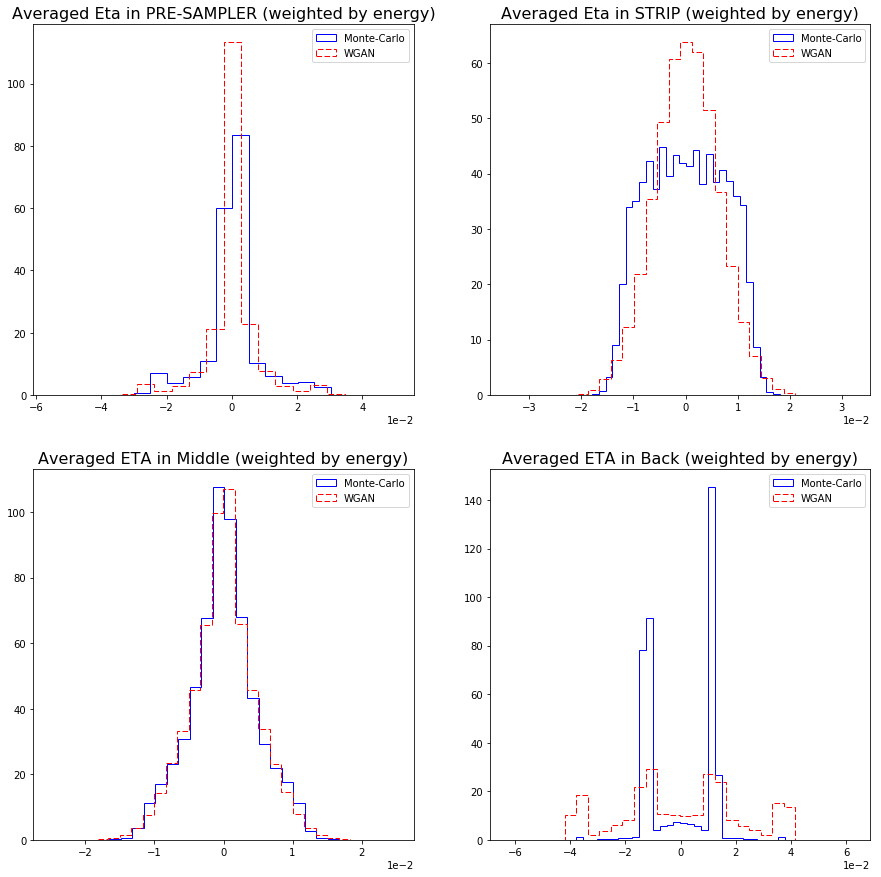

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0, 0].hist(avg_eta_t[:,0][~np.isnan(avg_eta_t[:,0])], bins=20, color='b', normed=1, histtype='step', label="Monte-Carlo")
ax[0, 0].hist(avg_eta_g[:,0][~np.isnan(avg_eta_g[:,0])], bins=20, color='r',normed=1,histtype='step', label="WGAN", linestyle='--')
ax[0, 0].set_title('Averaged Eta in PRE-SAMPLER (weighted by energy)', fontsize=16)
ax[0, 0].legend()
ax[0, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

ax[0, 1].hist(avg_eta_t[:,1][~np.isnan(avg_eta_t[:,1])], bins=30, color='b', normed=1,histtype='step', label="Monte-Carlo")
ax[0, 1].hist(avg_eta_g[:,1][~np.isnan(avg_eta_g[:,1])], bins=30,  color='r',normed=1,histtype='step', label="WGAN", linestyle='--')
ax[0, 1].set_title('Averaged Eta in STRIP (weighted by energy)', fontsize=16)
ax[0, 1].legend()
ax[0, 1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

ax[1, 0].hist(avg_eta_t[:,2][~np.isnan(avg_eta_t[:,2])], bins=30, color='b',  normed=1,histtype='step', label="Monte-Carlo")
ax[1, 0].hist(avg_eta_g[:,2][~np.isnan(avg_eta_g[:,2])], bins=30, color='r',  normed=1,histtype='step', label="WGAN", linestyle='--')
ax[1, 0].set_title('Averaged ETA in Middle (weighted by energy)', fontsize=16)
ax[1, 0].legend()
ax[1, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

ax[1, 1].hist(avg_eta_t[:,3][~np.isnan(avg_eta_t[:,3])], bins=30, color='b',  normed=1, histtype='step', label="Monte-Carlo")
ax[1, 1].hist(avg_eta_g[:,3][~np.isnan(avg_eta_g[:,3])], bins=30, color='r',normed=1, histtype='step', label="WGAN", linestyle='--')
ax[1, 1].set_title('Averaged ETA in Back (weighted by energy)', fontsize=16)
ax[1, 1].legend()
ax[1, 1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.legend()
if save == 'True':
    plt.savefig(path+'Averaged eta per layer.pdf', dpi=600)
plt.show()


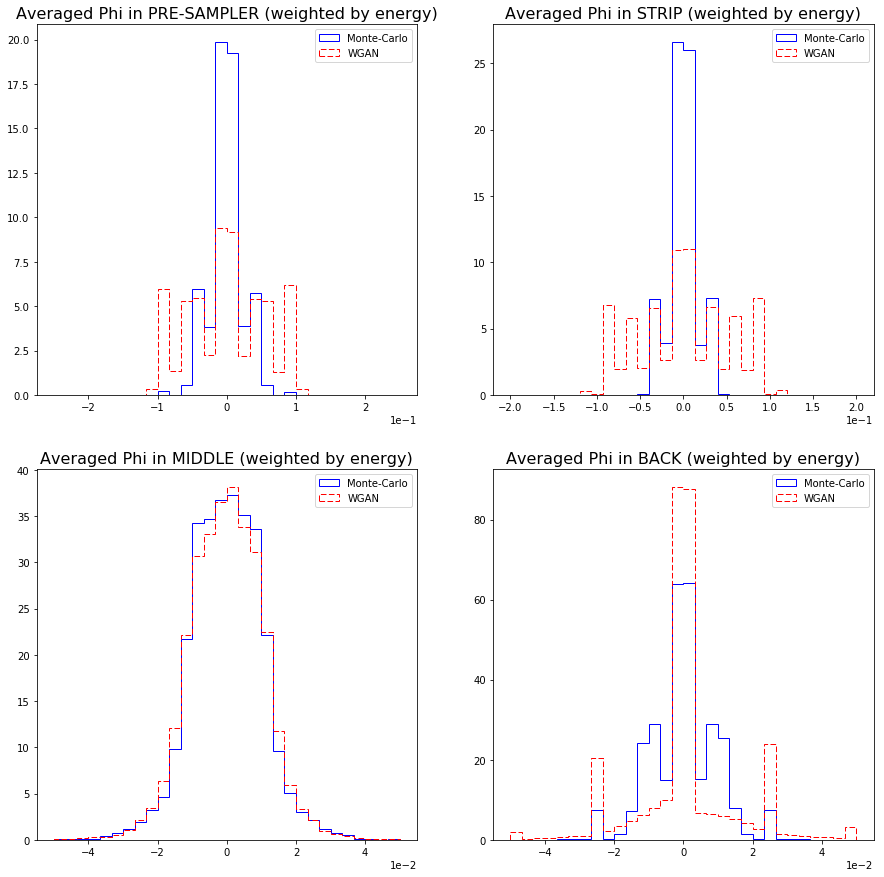

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0, 0].hist(avg_phi_t[:,0][~np.isnan(avg_phi_t[:,0])], bins=30, color='b',range=(-0.25,0.25),normed=1,histtype='step', label="Monte-Carlo")
ax[0, 0].hist(avg_phi_g[:,0][~np.isnan(avg_phi_g[:,0])], bins=30, color='r', range=(-0.25,0.25),normed=1,histtype='step', label="WGAN", linestyle='--')
ax[0, 0].set_title('Averaged Phi in PRE-SAMPLER (weighted by energy)', fontsize=16)
ax[0, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[0, 0].legend()


ax[0, 1].hist(avg_phi_t[:,1][~np.isnan(avg_phi_t[:,1])], bins=30, color='b',normed=1, range=(-0.2,0.2),histtype='step', label="Monte-Carlo")
ax[0, 1].hist(avg_phi_g[:,1][~np.isnan(avg_phi_g[:,1])], bins=30, color='r',normed=1,range=(-0.2,0.2),histtype='step', label="WGAN", linestyle='--')
ax[0, 1].set_title('Averaged Phi in STRIP (weighted by energy)', fontsize=16)
ax[0, 1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[0, 1].legend()

ax[1, 0].hist(avg_phi_t[:,2][~np.isnan(avg_phi_t[:,2])], bins=30, color='b',normed=1,histtype='step', range=(-0.05,0.05), label="Monte-Carlo")
ax[1, 0].hist(avg_phi_g[:,2][~np.isnan(avg_phi_g[:,2])], bins=30, color='r', normed=1,histtype='step', range=(-0.05,0.05), label="WGAN", linestyle='--')
ax[1, 0].set_title('Averaged Phi in MIDDLE (weighted by energy)', fontsize=16)
ax[1, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[1, 0].legend()

ax[1, 1].hist(avg_phi_t[:,3][~np.isnan(avg_phi_t[:,3])], bins=30, color='b',normed=1,histtype='step', range=(-0.05,0.05), label="Monte-Carlo")
ax[1, 1].hist(avg_phi_g[:,3][~np.isnan(avg_phi_g[:,3])], bins=30, color='r',normed=1,histtype='step',  range=(-0.05,0.05),label="WGAN", linestyle='--')
ax[1, 1].set_title('Averaged Phi in BACK (weighted by energy)', fontsize=16)
ax[1, 1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[1, 1].legend()

if save == 'True':
    plt.savefig(path+'Average phi per layer.pdf', dpi=600)
plt.show()

### Emiddle centre 

Percent of energy in the 3x3 cells in the centre of Middle layer (compared to the entire cluster 3x7 in Middle).

In [28]:
E_middle_t = E_layer_t[:,2]
E_middle_g = E_layer_g[:,2]

In [29]:
#Compute E(3*3)/E(7*3), taking cluster at the center of the 7*3 rectangle
E_middle_centre_t = np.zeros((X_t.shape[0]))
for i in range(X_t.shape[0]):
    E_middle_centre_t[i] = X_t[i][:21][::-1].reshape(3,7).transpose()[2:5].sum()/E_middle_t[i]
    
E_middle_centre_g = np.zeros((X_g.shape[0]))
for i in range(X_g.shape[0]):
    E_middle_centre_g[i] = X_g[i][:21][::-1].reshape(3,7).transpose()[2:5].sum()/E_middle_g[i]

/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


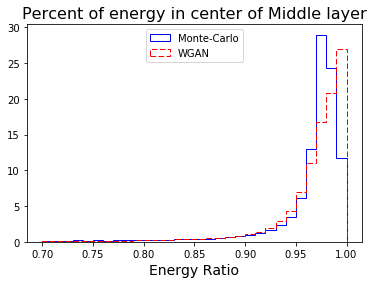

In [30]:
plt.hist(E_middle_centre_t[~np.isnan(E_middle_centre_t)], histtype='step', color='b', label='Monte-Carlo', bins=30, normed=1, range=(0.7,1))
plt.hist(E_middle_centre_g[~np.isnan(E_middle_centre_g)], histtype='step', color='r', label='WGAN', bins=30, normed=1, range=(0.7,1), linestyle='--')
plt.title('Percent of energy in center of Middle layer', fontsize=16)
plt.legend(loc='upper center')
plt.xlabel('Energy Ratio', fontsize=14)
if save == 'True':
    plt.savefig(path+'Percent Energy Middle.pdf', dpi=600)
plt.show()

### RMS - Middle (eta)

In [31]:
eta = [a[i][3][:89] for i in range(X_t.shape[0])]*seeds
eta_square = [e*e for e in eta]

In [32]:
from math import sqrt
rms_eta_middle_t = [(np.dot(X_t[i][:21], eta_square[i][:21])*E_layer_t[i][2] - np.dot(X_t[i][:21], eta[i][:21])**2)/(E_layer_t[i][2])**2 for i in range(X_t.shape[0])]
rms_eta_sampler_t = [(np.dot(X_t[i][69:75], eta_square[i][69:75])*E_layer_t[i][0] - np.dot(X_t[i][69:75], eta[i][69:75])**2)/(E_layer_t[i][0])**2 for i in range(X_t.shape[0])]
rms_eta_strip_t = [(np.dot(X_t[i][21:69], eta_square[i][21:69])*E_layer_t[i][1] - np.dot(X_t[i][21:69],eta[i][21:69])**2)/(E_layer_t[i][1])**2 for i in range(X_t.shape[0])]
rms_eta_back_t = [(np.dot(X_t[i][75:89], eta_square[i][75:89])*E_layer_t[i][3] - np.dot(X_t[i][75:89], eta[i][75:89])**2)/(E_layer_t[i][2])**2 for i in range(X_t.shape[0])]

rms_eta_middle_g = [(np.dot(X_g[i][:21], eta_square[i][:21])*E_layer_g[i][2] - np.dot(X_g[i][:21], eta[i][:21])**2)/(E_layer_g[i][2])**2 for i in range(X_g.shape[0])]
rms_eta_sampler_g = [(np.dot(X_g[i][69:75], eta_square[i][69:75])*E_layer_g[i][0] - np.dot(X_g[i][69:75], eta[i][69:75])**2)/(E_layer_g[i][0])**2 for i in range(X_g.shape[0])]
rms_eta_strip_g = [(np.dot(X_g[i][21:69], eta_square[i][21:69])*E_layer_g[i][1] - np.dot(X_g[i][21:69],eta[i][21:69])**2)/(E_layer_g[i][1])**2 for i in range(X_g.shape[0])]
rms_eta_back_g = [(np.dot(X_g[i][75:89], eta_square[i][75:89])*E_layer_g[i][3] - np.dot(X_g[i][75:89], eta[i][75:89])**2)/(E_layer_g[i][2])**2 for i in range(X_g.shape[0])]

rms_eta_middle_t = np.asarray(rms_eta_middle_t)
rms_eta_sampler_t = np.asarray(rms_eta_sampler_t)
rms_eta_strip_t = np.asarray(rms_eta_strip_t)
rms_eta_back_t = np.asarray(rms_eta_back_t)

rms_eta_middle_g = np.asarray(rms_eta_middle_g)
rms_eta_sampler_g = np.asarray(rms_eta_sampler_g)
rms_eta_strip_g = np.asarray(rms_eta_strip_g)
rms_eta_back_g = np.asarray(rms_eta_back_g)


/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: 

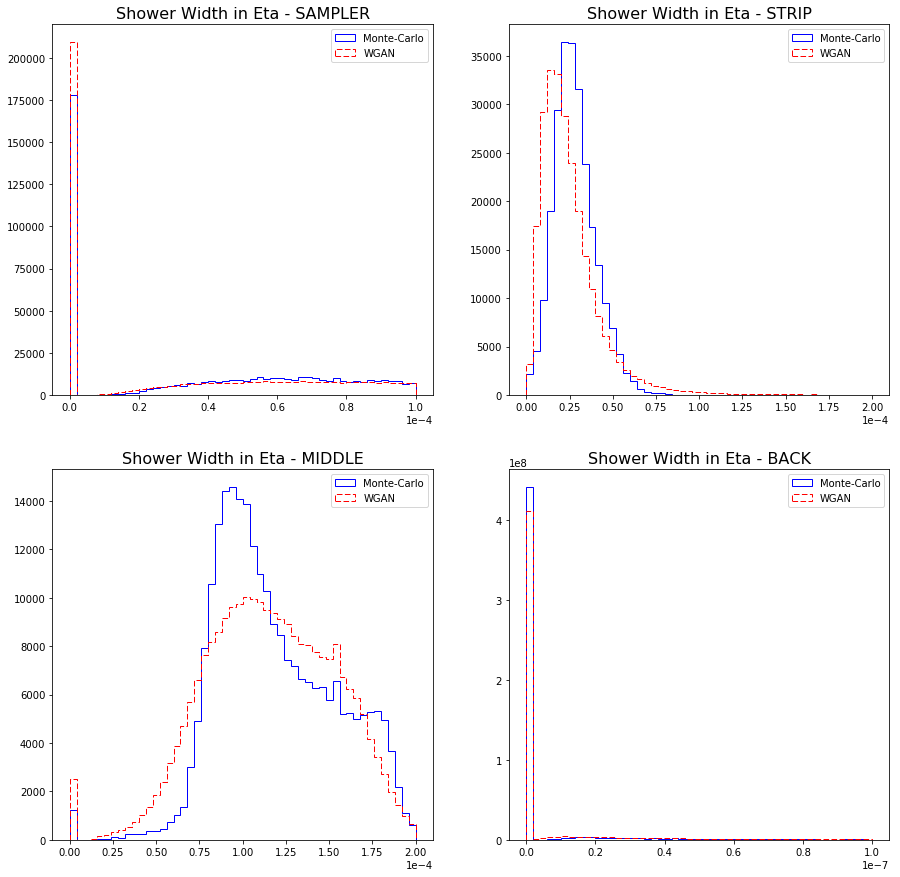

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0, 0].hist(rms_eta_sampler_t[~np.isnan(rms_eta_sampler_t)], histtype='step', range=(0,0.0001), bins=50, normed=1, color='b', label='Monte-Carlo')
ax[0, 0].hist(rms_eta_sampler_g[~np.isnan(rms_eta_sampler_g)], histtype='step', range=(0,0.0001),bins=50, normed=1, color='r', label='WGAN', linestyle='--')
ax[0, 0].set_title('Shower Width in Eta - SAMPLER', fontsize=16)
ax[0, 0].legend()
ax[0, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

ax[0, 1].hist(rms_eta_strip_t[~np.isnan(rms_eta_strip_t)], bins=50, color='b',range=(0,0.0002), normed=1,histtype='step', label="Monte-Carlo")
ax[0, 1].hist(rms_eta_strip_g[~np.isnan(rms_eta_strip_g)], bins=50, color='r', range=(0,0.0002),normed=1,histtype='step', label="WGAN", linestyle='--')
ax[0, 1].set_title('Shower Width in Eta - STRIP', fontsize=16)
ax[0, 1].legend()
ax[0, 1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

ax[1, 0].hist(rms_eta_middle_t[~np.isnan(rms_eta_middle_t)], bins=50, color='b', normed=1,range=(0,0.0002), histtype='step', label="Monte-Carlo")
ax[1, 0].hist(rms_eta_middle_g[~np.isnan(rms_eta_middle_g)], bins=50, color='r', normed=1,range=(0,0.0002), histtype='step', label="WGAN", linestyle='--')
ax[1, 0].set_title('Shower Width in Eta - MIDDLE', fontsize=16)
ax[1, 0].legend()
ax[1, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

ax[1, 1].hist(rms_eta_back_t[~np.isnan(rms_eta_back_t)], bins=50, color='b', normed=1,histtype='step',range=(0,0.0000001), label="Monte-Carlo")
ax[1, 1].hist(rms_eta_back_g[~np.isnan(rms_eta_back_g)], bins=50, color='r', normed=1,histtype='step',range=(0,0.0000001), label="WGAN", linestyle='--')
ax[1, 1].set_title('Shower Width in Eta - BACK', fontsize=16)
ax[1, 1].legend()
ax[1, 1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

if save == 'True':
    plt.savefig(path+'RMS_Eta.pdf', dpi=600)
plt.show()

In [34]:
phi = [a[i][4][:89] for i in range(X_t.shape[0])]*seeds
phi_square = [p*p for p in phi]

In [35]:
from math import sqrt
rms_phi_middle_t = [(np.dot(X_t[i][:21], phi_square[i][:21])*E_layer_t[i][2] - np.dot(X_t[i][:21], phi[i][:21])**2)/(E_layer_t[i][2])**2 for i in range(X_t.shape[0])]
rms_phi_sampler_t = [(np.dot(X_t[i][69:75], phi_square[i][69:75])*E_layer_t[i][0] - np.dot(X_t[i][69:75], phi[i][69:75])**2)/(E_layer_t[i][0])**2 for i in range(X_t.shape[0])]
rms_phi_strip_t = [(np.dot(X_t[i][21:69], phi_square[i][21:69])*E_layer_t[i][1] - np.dot(X_t[i][21:69],phi[i][21:69])**2)/(E_layer_t[i][1])**2 for i in range(X_t.shape[0])]
rms_phi_back_t = [(np.dot(X_t[i][75:89], phi_square[i][75:89])*E_layer_t[i][3] - np.dot(X_t[i][75:89], phi[i][75:89])**2)/(E_layer_t[i][2])**2 for i in range(X_t.shape[0])]

rms_phi_middle_g = [(np.dot(X_g[i][:21], phi_square[i][:21])*E_layer_g[i][2] - np.dot(X_g[i][:21], phi[i][:21])**2)/(E_layer_g[i][2])**2 for i in range(X_g.shape[0])]
rms_phi_sampler_g = [(np.dot(X_g[i][69:75], phi_square[i][69:75])*E_layer_g[i][0] - np.dot(X_g[i][69:75], phi[i][69:75])**2)/(E_layer_g[i][0])**2 for i in range(X_g.shape[0])]
rms_phi_strip_g = [(np.dot(X_g[i][21:69], phi_square[i][21:69])*E_layer_g[i][1] - np.dot(X_g[i][21:69], phi[i][21:69])**2)/(E_layer_g[i][1])**2 for i in range(X_g.shape[0])]
rms_phi_back_g = [(np.dot(X_g[i][75:89], phi_square[i][75:89])*E_layer_g[i][3] - np.dot(X_g[i][75:89], phi[i][75:89])**2)/(E_layer_g[i][2])**2 for i in range(X_g.shape[0])]

/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: 

/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


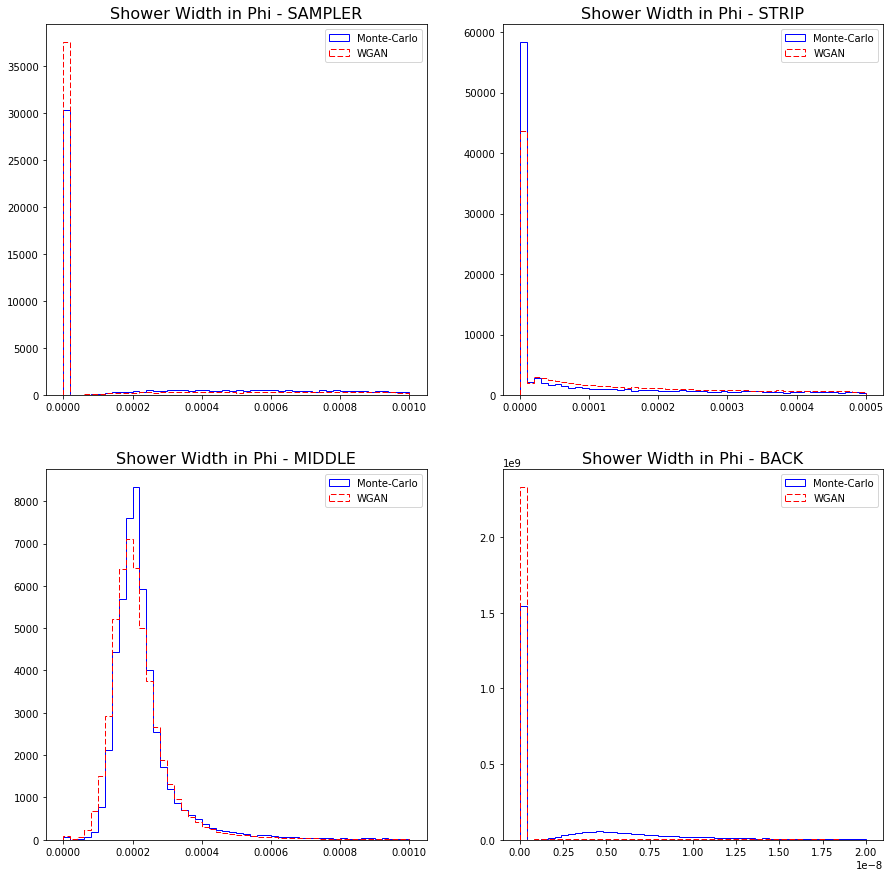

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0, 0].hist(rms_phi_sampler_t, histtype='step', bins=50, normed=1, range=(0, 0.001), color='b', label='Monte-Carlo')
ax[0, 0].hist(rms_phi_sampler_g, histtype='step', bins=50, normed=1, range=(0,0.001), color='r', label='WGAN', linestyle='--')
ax[0, 0].set_title('Shower Width in Phi - SAMPLER', fontsize=16)
ax[0, 0].legend()

ax[0, 1].hist(rms_phi_strip_t, bins=50, color='b', normed=1,histtype='step', range=(0,0.0005), label="Monte-Carlo")
ax[0, 1].hist(rms_phi_strip_g, bins=50, color='r', normed=1,histtype='step', range=(0,0.0005),label="WGAN", linestyle='--')
ax[0, 1].set_title('Shower Width in Phi - STRIP', fontsize=16)
ax[0, 1].legend()

ax[1, 0].hist(rms_phi_middle_t, bins=50, color='b', normed=1,histtype='step',range=(0,0.001), label="Monte-Carlo")
ax[1, 0].hist(rms_phi_middle_g, bins=50, color='r', normed=1,histtype='step',range=(0,0.001), label="WGAN", linestyle='--')
ax[1, 0].set_title('Shower Width in Phi - MIDDLE', fontsize=16)
ax[1, 0].legend()

ax[1, 1].hist(rms_phi_back_t, bins=50, color='b', normed=1,histtype='step', range=(0,0.00000002),label="Monte-Carlo")
ax[1, 1].hist(rms_phi_back_g, bins=50, color='r', normed=1,histtype='step', range=(0,0.00000002),label="WGAN", linestyle='--')
ax[1, 1].set_title('Shower Width in Phi - BACK', fontsize=16)
ax[1, 1].legend()

if save == 'True':
    plt.savefig(path+'RMS_Phi.pdf', dpi=600)
plt.show()

### RMS w.r.t energy

Here is the classic plot of Shower Width (Eta - Middle), with respect to the energy of the event

In [37]:
E = range(0, 30000, 1000)
E.extend(range(30000, 305000, 5000))

from operator import add
E_ = E[:len(E)-1]
_E = E[1:]
energies = map(add, E_,_E)
energies = np.asarray([e/2 for e in energies])

E_ = np.asarray(energies).reshape(-1,1)
E_ = np.log(E_)
E_scaled = scaler.fit_transform(E_)

In [38]:
rms_mean = []
for i in range(len(E)-1):  
    indices = np.where((E[i]<E_tot_t) & (E_tot_t<E[i+1]))
    rms = np.take(rms_phi_middle_t, indices[0])
    rms_mean.append(np.nanmean(rms))
    
rms_mean = np.asarray(rms_mean)
rms_mean_ = np.sqrt(rms_mean)

/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [39]:
rms_mean_g = []
for i in range(E_scaled.shape[0]):
    X_gen_norm = generator_12.predict([np.random.normal(0,1,(2000, SIZE_Z)).astype(np.float32), np.ones((2000,1))*E_scaled[i]])
    X_g_ = X_gen_norm * energies[i]
    
    for i in range(X_g_.shape[0]):
        for j in range(89):
            if (j<21) & (X_g_[i][j] < 200):
                X_g_[i][j] = 0
            elif (21<=j<69) & (X_g_[i][j] < 60):
                X_g_[i][j] = 0
            elif (69<=j<75) & (X_g_[i][j] < 120):
                X_g_[i][j] = 0
            elif (75<=j<89) & (X_g_[i][j] < 200):
                X_g_[i][j] = 0
    
    indices_ = np.asarray(range(X_t.shape[0]))
    np.random.shuffle(indices_)
    indices = indices_[:2000] # to have random coordinates in phi and eta
    E_layer_g = np.zeros((2000, 4))
    
    for k in range(2000):
        E_layer_g[k][2] = X_g_[k][:21].sum() #Middle
        
    rms_phi_middle_g = [(np.dot(X_g_[j][:21], phi_square[indices[j]][:21])*E_layer_g[j][2] - np.dot(X_g_[j][:21], phi[indices[j]][:21])**2)/(E_layer_g[j][2])**2 for j in range(1000)]
    
    rms_mean_g.append(np.nanmean(rms_phi_middle_g))
    
rms_mean_g = np.asarray(rms_mean_g)
rms_mean_g_ = np.sqrt(rms_mean_g)

/home/pklein/src/anaconda2/envs/CERN/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


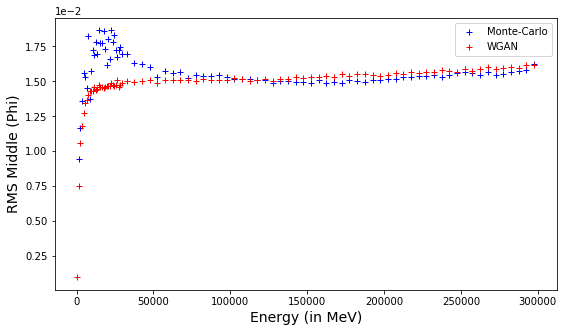

In [49]:
plt.figure(figsize=(9,5))
plt.plot(energies, rms_mean_, '+', label='Monte-Carlo', color='b')
plt.plot(energies, rms_mean_g_, '+', label='WGAN', color='r')
plt.xlabel('Energy (in MeV)', fontsize=14)
plt.ylabel('RMS Middle (Phi)', fontsize=14)
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('RMS_Energy.pdf')
plt.show()

### Middle - 2D images

In [90]:
X_t_mean = X_t.mean(axis=0)
X_g_mean = X_g.mean(axis=0) 

In [93]:
def pixel_middle(X_t_sample, X_g_sample):
    '''Takes as inputs two samples (typically one coming from MC distribution and 
    the other one from WGAN distribution).
    Ouptut pixeled images of Middle layer'''

    # MIDDLE pixels
    X_t_sample_ = X_t_sample[:21][::-1].reshape(3,7).transpose()
    X_g_sample_ = X_g_sample[:21][::-1].reshape(3,7).transpose() 
    fig, ax = plt.subplots(1,2)


    vmin = np.ndarray.min(np.concatenate((X_g_sample_, X_t_sample_), axis=0))
    vmax = np.ndarray.max(np.concatenate((X_g_sample_, X_t_sample_), axis=0))

    norm = colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=vmin, vmax=vmax)
    ax[0].imshow(X_t_sample_, norm=norm, origin='lower', cmap='viridis')
    ax[0].set_title('Monte-Carlo', fontsize=15)
    ax[0].set_yticks([])
    ax[0].set_xticks([])

    relative_error = np.mean(np.absolute(np.divide((X_g_sample_ - X_t_sample_), X_t_sample_)))
    im = ax[1].imshow(X_g_sample_, norm=norm, origin='lower', cmap='viridis')
    ax[1].set_title('WGAN', fontsize=15)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_xlabel(relative_error)
    
    cax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    plt.tight_layout()
    plt.colorbar(im, cax=cax)
    plt.show()

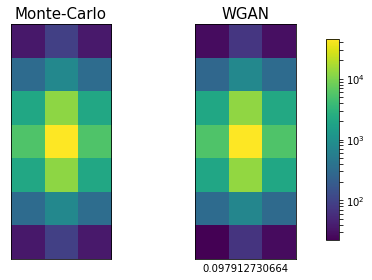

In [94]:
pixel_middle(X_t_mean, X_g_mean)

### Strip - 2D Images 

In [105]:
def pixel_strip(X_t_sample, X_g_sample):
    '''Takes as inputs two samples (typically one coming from MC distribution and 
    the other one from WGAN distribution).
    Ouptut pixeled images of Strip layer'''
    
    # STRIP pixels
    X_t_sample_ = X_t_sample[21:69][::-1].reshape(24,2).transpose()
    X_g_sample_ = X_g_sample[21:69][::-1].reshape(24,2).transpose() 
    fig, ax = plt.subplots(1,2)


    vmin = np.ndarray.min(np.concatenate((X_g_sample_, X_t_sample_), axis=0))
    vmax = np.ndarray.max(np.concatenate((X_g_sample_, X_t_sample_), axis=0))

    norm = colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=vmin, vmax=vmax)
    ax[0].imshow(X_t_sample_, norm=norm, origin='lower', cmap='viridis', extent=[0, 24,0, 2], aspect=24)
    ax[0].set_title('Monte-Carlo', fontsize=15)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    
    relative_error = np.mean(np.absolute(np.divide((X_g_sample_+1e-6 - X_t_sample_), (X_t_sample_+1e-6))))
    im = ax[1].imshow(X_g_sample_, norm=norm, origin='lower', cmap='viridis', extent=[0, 24,0, 2], aspect=24)
    ax[1].set_title('WGAN', fontsize=15)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_xlabel(relative_error)

    cax = fig.add_axes([1.0, 0.15, 0.03, 0.7])
    plt.tight_layout()
    plt.colorbar(im, cax=cax)
    plt.show()

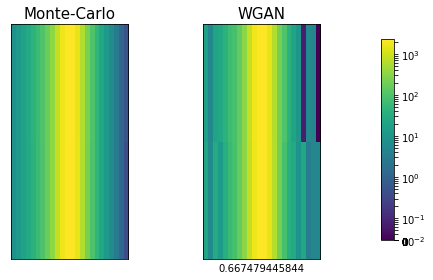

In [106]:
pixel_strip(X_t_mean, X_g_mean)

### Back - 2D Images

In [34]:
def pixel_back(X_t_sample, X_g_sample):
    '''Takes as inputs two samples (typically one coming from MC distribution and 
    the other one from WGAN distribution).
    Ouptut pixeled images of Strip layer'''


    # BACK pixels
    X_t_sample_ = X_t_sample[75:89][::-1].reshape(2,7).transpose()
    X_g_sample_ = X_g_sample[75:89][::-1].reshape(2,7).transpose() 
    fig, ax = plt.subplots(1,2)

    vmin = np.ndarray.min(np.concatenate((X_g_sample_, X_t_sample_), axis=0))
    vmax = np.ndarray.max(np.concatenate((X_g_sample_, X_t_sample_), axis=0))

    norm = colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=vmin, vmax=vmax)
    ax[0].imshow(X_t_sample_, norm=norm, origin='lower', cmap='viridis', extent=[0, 7,0, 2], aspect=7)
    ax[0].set_title('Monte-Carlo', fontsize=15)
    ax[0].set_yticks([])
    ax[0].set_xticks([])

    relative_error = np.mean(np.divide(np.absolute(X_g_sample_ - X_t_sample_), X_t_sample_))
    im = ax[1].imshow(X_g_sample_, norm=norm, origin='lower', cmap='viridis', extent=[0, 7,0, 2], aspect=7)
    ax[1].set_title('WGAN', fontsize=15)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_xlabel(relative_error)

    cax = fig.add_axes([1.0, 0.15, 0.03, 0.7])
    plt.tight_layout()
    plt.colorbar(im, cax=cax)
    plt.show()

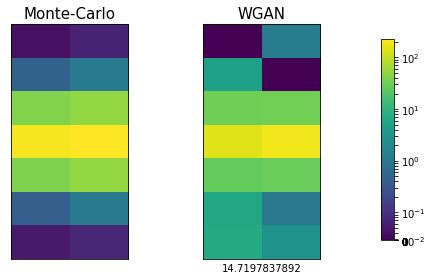

In [35]:
pixel_back(X_t_mean, X_g_mean)

### Pre-sampler - 2D Images 

In [223]:
def pixel_sampler(X_t_sample, X_g_sample):
    '''Takes as inputs two samples (typically one coming from MC distribution and 
    the other one from WGAN distribution).
    Ouptut pixeled images of Strip layer'''

    # SAMPLER pixels
    X_t_sample_ = X_t_sample[69:75][::-1].reshape(3,2).transpose()
    X_g_sample_ = X_g_sample[69:75][::-1].reshape(3,2).transpose() 
    fig, ax = plt.subplots(1,2)

    vmin = np.ndarray.min(np.concatenate((X_g_sample_, X_t_sample_), axis=0))
    vmax = np.ndarray.max(np.concatenate((X_g_sample_, X_t_sample_), axis=0))

    norm = colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=vmin, vmax=vmax)
    ax[0].imshow(X_t_sample_, norm=norm, origin='lower', cmap='viridis')
    ax[0].set_title('Monte-Carlo', fontsize=15)
    ax[0].set_yticks([])
    ax[0].set_xticks([])

    im = ax[1].imshow(X_g_sample_, norm=norm, origin='lower', cmap='viridis')
    ax[1].set_title('WGAN', fontsize=15)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    cax = fig.add_axes([1.0, 0.15, 0.03, 0.7])
    plt.tight_layout()
    plt.colorbar(im, cax=cax)
    plt.show()

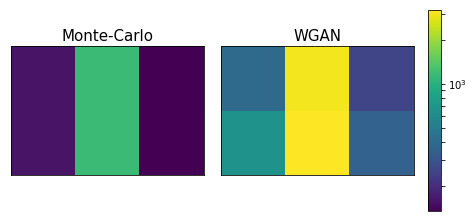

In [224]:
pixel_sampler(X_t_mean, X_g_mean)

### Covariance

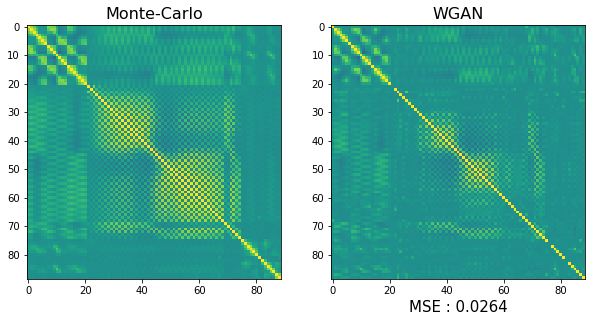

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cov = []
fig, ax = plt.subplots(1, 2, figsize=(10,10))

scaler_ = StandardScaler()
X_t_ = scaler_.fit_transform(X_t)
pca = PCA()
pca.fit(X_t_)
cov.append(pca.get_covariance())

scaler_ = StandardScaler()
value_ = scaler_.fit_transform(X_g)
pca = PCA()
pca.fit(value_)
cov.append(pca.get_covariance())

#Plots
# vmin = np.asarray(cov).min()
# vmax = np.asarray(cov).max()
vmin = -1
vmax = 1
mse = np.mean((cov[0] - cov[1])**2)


ax[0].imshow(cov[0], vmin=vmin, vmax=vmax)
ax[0].set_title('Monte-Carlo', fontsize=16)

ax[1].imshow(cov[1], vmin=vmin, vmax=vmax)
ax[1].set_title('WGAN', fontsize=16)
ax[1].set_xlabel('MSE : {}'.format(round(mse, 5)), fontsize=15)
plt.savefig('Covariance.pdf')

plt.show()

### Generation of images

In [322]:
E_ = scaler.inverse_transform(E_tot) #Apply inverse StandardScaler
E = np.exp(E_.reshape(E_.shape[0])[:,np.newaxis]) #Take the exp to recover real energy value of the event

In [331]:
def event_comparison(energy=None):
    '''Plot an event from MC and WGAN distribution of the same conditioned energy.
    You can select an energy width by defining a lower bound a and an upper bound b.
    Energy will be picked between a and b.
    Otherwise, energy is selected randomly in the dataset.
    Output the energy (in MeV)'''
    
    if energy is None:
        i = random.randint(0, E.shape[0])
    else:
        assert (len(energy)==2) & (energy[0]<=energy[1])
        idx = np.where(np.logical_and(E>=energy[0], E<=energy[1]))[0]
        i = np.random.permutation(idx)[0]
              
    pixel_sampler(X_t[i], X_g[i])
    pixel_strip(X_t[i], X_g[i])
    pixel_middle(X_t[i], X_g[i])
    pixel_back(X_t[i], X_g[i])
    return round(E[i])

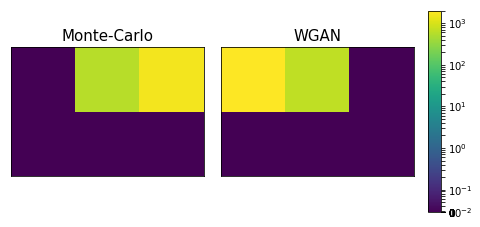

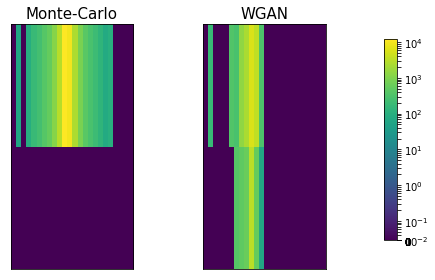

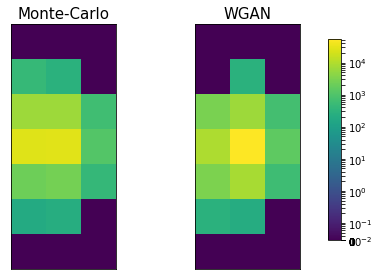

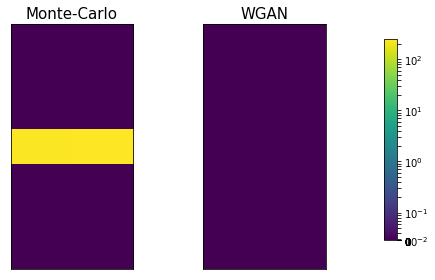

113721.0

In [332]:
event_comparison(energy=(100000,200000))

### Nearest Neighbors

In [18]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(5)
neigh.fit(X_g[:,:21])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [32]:
def plot_images(image):
    # compute the 5 nearest neighbors to input image
    arr = neigh.kneighbors(image[:21].reshape(1,-1), 5, return_distance=False)[0]
    images = [X_g[neigh_i][:21] for neigh_i in arr]
    images.insert(0, image[:21])
    
    #subplots
    assert len(images) == 6  
    vmin = 1
    vmax = image[:21].max()
    norm = colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=vmin, vmax=vmax)
    fig, axes = plt.subplots(3, 2, figsize=(8,8))

    for i, ax in enumerate(axes.flat):
        # Plot image.
        
        im = ax.imshow(images[i][::-1].reshape(3,7).transpose(), norm=norm, origin='lower', cmap='viridis')

        # Show true and predicted classes.
        if i==0:
            title = "Real shower"
        else:
            title = "Generated shower: {}".format(i)

        ax.set_title(title, fontsize=12)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    cax = fig.add_axes([0.9, 0.25, 0.03, 0.5])
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('MeV')
    plt.savefig('Nearest_Neighbors.pdf')
    plt.show()
    return images

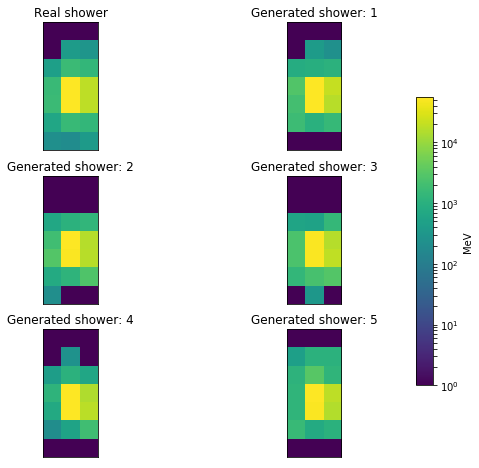

In [33]:
t = plot_images(X_t[1])

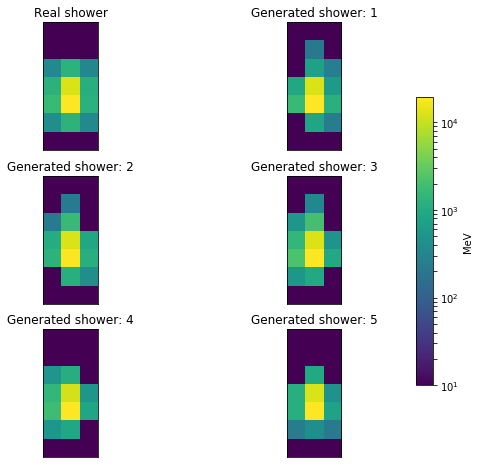

In [29]:
t = plot_images(X_t[0])

In [ ]:
#soit mémorise tout le dataset (pas possible). Autre problème mémorise que quelques exemples (mode collapse), 
#mais à ce moment-là plus petite variance pour les événements générés --> A VERIFIER

### Variance per cell --> Second order Momentum

In [58]:
std_true = np.std(X_t, axis=0)

In [59]:
std_gen = np.std(X_g, axis=0)

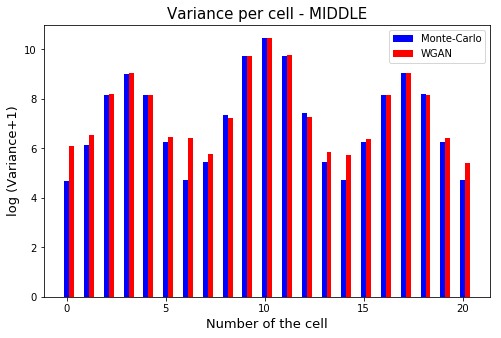

In [60]:
plt.figure(figsize=(8,5))
width = 0.25
plt.bar(np.arange(21), np.log(std_true[:21]+1), width, color='b', label='Monte-Carlo')
plt.bar(np.arange(21)+width, np.log(std_gen[:21]+1), width, color='r', label='WGAN')

plt.legend(loc='upper right')
plt.title('Variance per cell - MIDDLE', fontsize=15)
plt.xlabel('Number of the cell', fontsize=13)
plt.ylabel('log (Variance+1)', fontsize=13)
plt.savefig('Variance_per_cell_MIDDLE.pdf')
plt.show()

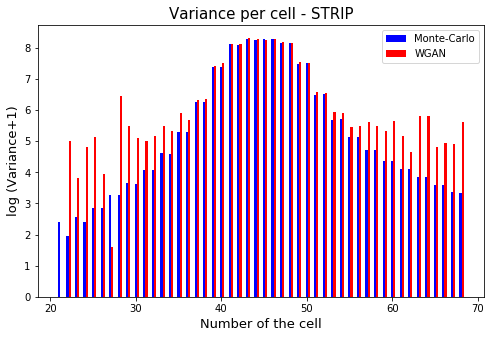

In [61]:
plt.figure(figsize=(8,5))
width = 0.25
plt.bar(np.arange(21,69), np.log(std_true[21:69]+1), width, color='b', label='Monte-Carlo')
plt.bar(np.arange(21,69)+width, np.log(std_gen[21:69]+1), width, color='r', label='WGAN')

plt.legend(loc='upper right')
plt.title('Variance per cell - STRIP', fontsize=15)
plt.xlabel('Number of the cell', fontsize=13)
plt.ylabel('log (Variance+1)', fontsize=13)
plt.savefig('Variance_per_cell_STRIP.pdf')
plt.show()

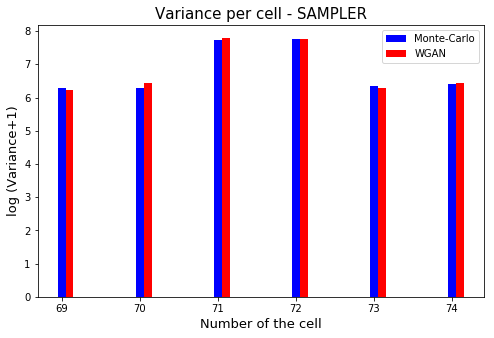

In [62]:
plt.figure(figsize=(8,5))
width = 0.1
plt.bar(np.arange(69,75), np.log(std_true[69:75]+1), width, color='b', label='Monte-Carlo')
plt.bar(np.arange(69,75)+width, np.log(std_gen[69:75]+1), width, color='r', label='WGAN')

plt.legend(loc='upper right')
plt.title('Variance per cell - SAMPLER', fontsize=15)
plt.xlabel('Number of the cell', fontsize=13)
plt.ylabel('log (Variance+1)', fontsize=13)
plt.savefig('Variance_per_cell_SAMPLER.pdf')
plt.show()

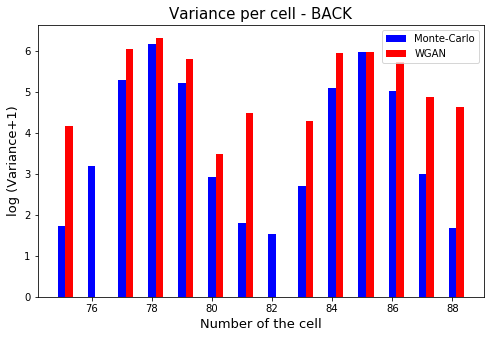

In [63]:
plt.figure(figsize=(8,5))
width = 0.25
plt.bar(np.arange(75,89), np.log(std_true[75:89]+1), width, color='b', label='Monte-Carlo')
plt.bar(np.arange(75,89)+width, np.log(std_gen[75:89]+1), width, color='r', label='WGAN')

plt.legend(loc='upper right')
plt.title('Variance per cell - BACK', fontsize=15)
plt.xlabel('Number of the cell', fontsize=13)
plt.ylabel('log (Variance+1)', fontsize=13)
plt.savefig('Variance_per_cell_BACK.pdf')
plt.show()

Clearly no mode collapse (otherwise we would have a low variance for WGAN generated events). However, highest variance in general for GAN: it is buil to reproduce first order momentum (mean), but not perfectly higher momentum (especially variance).

### Mean value per cell --> First order Momentum

In [128]:
mean_true = np.mean(X_t, axis=0)

In [130]:
mean_gen = np.mean(X_g, axis=0)

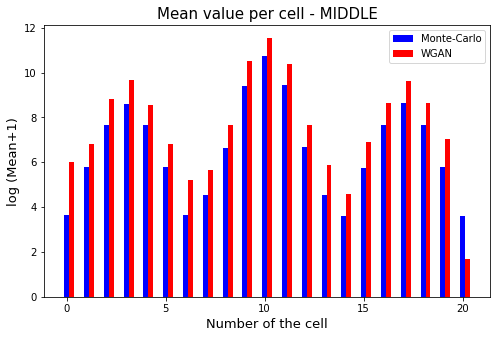

In [133]:
plt.figure(figsize=(8,5))
width = 0.25
plt.bar(np.arange(21), np.log(mean_true[:21]+1), width, color='b', label='Monte-Carlo')
plt.bar(np.arange(21)+width, np.log(mean_gen[:21]+1), width, color='r', label='WGAN')

plt.legend(loc='upper right')
plt.title('Mean value per cell - MIDDLE', fontsize=15)
plt.xlabel('Number of the cell', fontsize=13)
plt.ylabel('log (Mean+1)', fontsize=13)
plt.show()

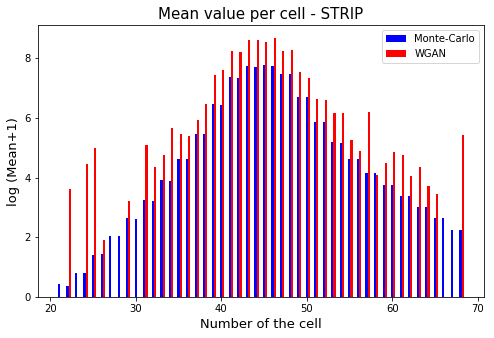

In [134]:
plt.figure(figsize=(8,5))
width = 0.25
plt.bar(np.arange(21,69), np.log(mean_true[21:69]+1), width, color='b', label='Monte-Carlo')
plt.bar(np.arange(21,69)+width, np.log(mean_gen[21:69]+1), width, color='r', label='WGAN')

plt.legend(loc='upper right')
plt.title('Mean value per cell - STRIP', fontsize=15)
plt.xlabel('Number of the cell', fontsize=13)
plt.ylabel('log (Mean+1)', fontsize=13)
plt.show()

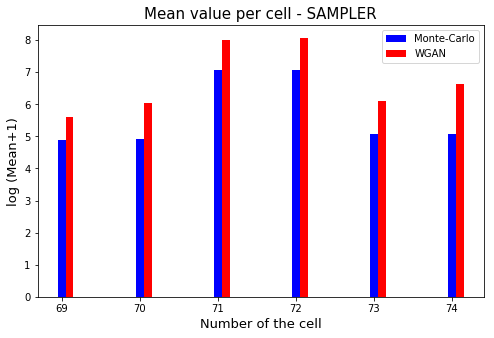

In [137]:
plt.figure(figsize=(8,5))
width = 0.1
plt.bar(np.arange(69,75), np.log(mean_true[69:75]+1), width, color='b', label='Monte-Carlo')
plt.bar(np.arange(69,75)+width, np.log(mean_gen[69:75]+1), width, color='r', label='WGAN')

plt.legend(loc='upper right')
plt.title('Mean value per cell - SAMPLER', fontsize=15)
plt.xlabel('Number of the cell', fontsize=13)
plt.ylabel('log (Mean+1)', fontsize=13)
plt.show()

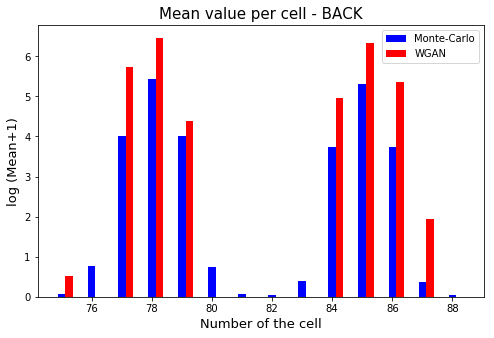

In [139]:
plt.figure(figsize=(8,5))
width = 0.25
plt.bar(np.arange(75,89), np.log(mean_true[75:89]+1), width, color='b', label='Monte-Carlo')
plt.bar(np.arange(75,89)+width, np.log(mean_gen[75:89]+1), width, color='r', label='WGAN')

plt.legend(loc='upper right')
plt.title('Mean value per cell - BACK', fontsize=15)
plt.xlabel('Number of the cell', fontsize=13)
plt.ylabel('log (Mean+1)', fontsize=13)
plt.show()